## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 4 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp005'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 4 # 6
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([4, 224, 224])

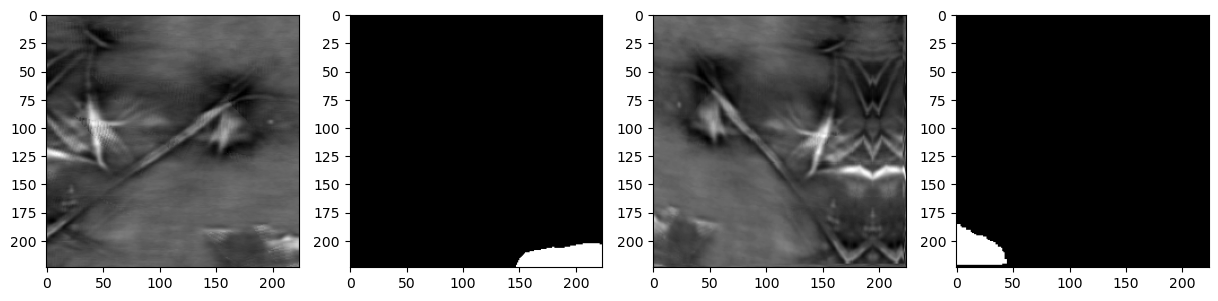

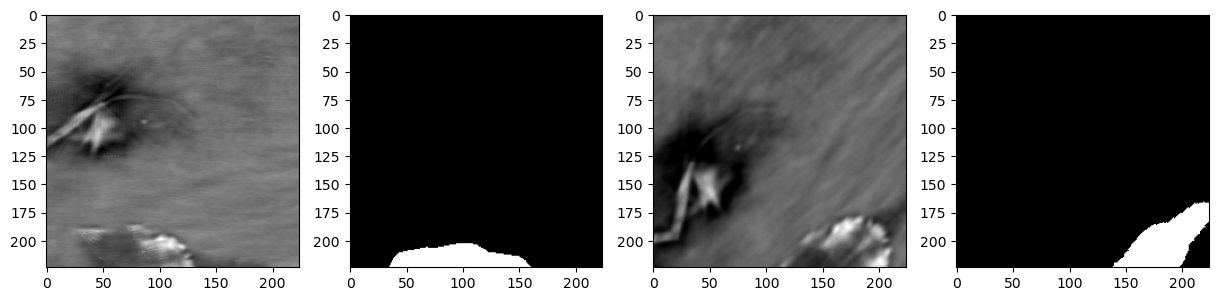

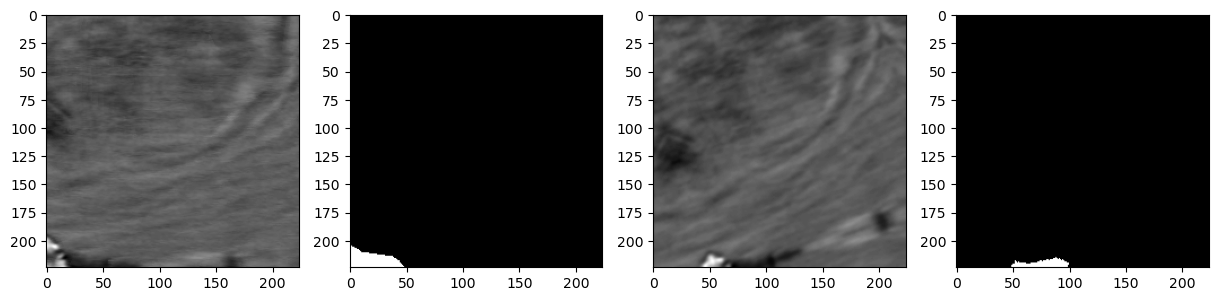

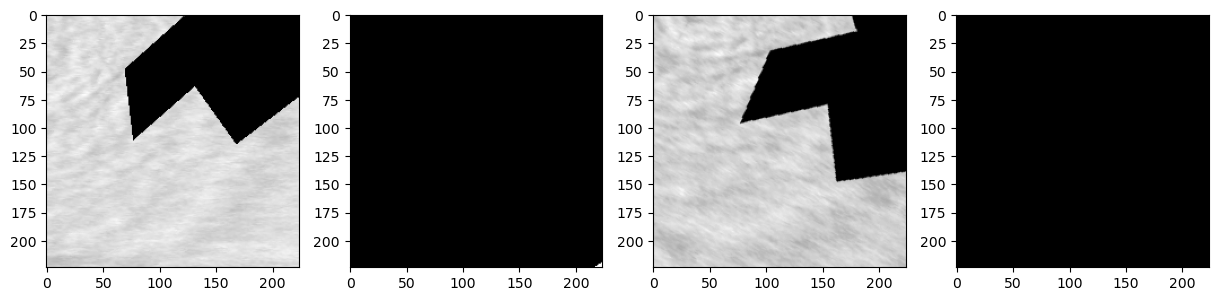

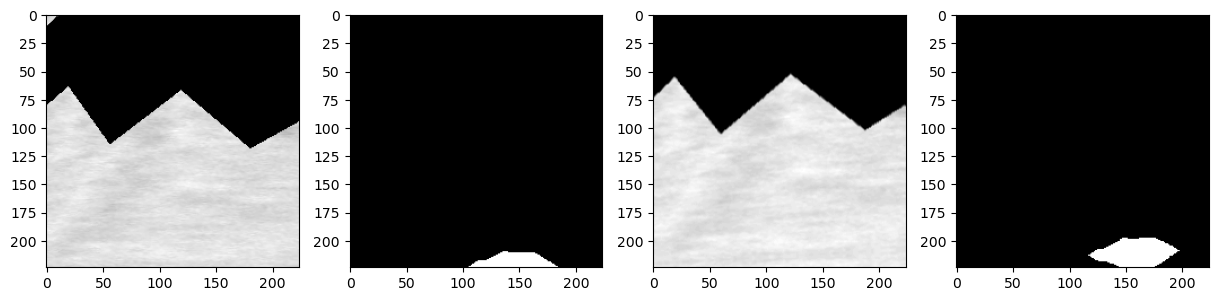

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.129675491880738
th: 0.15, fbeta: 0.22567145618443632
th: 0.2, fbeta: 0.2520405348770802
th: 0.25, fbeta: 0.2832946375523667
th: 0.3, fbeta: 0.3210968695270945
th: 0.35, fbeta: 0.3635863065263073
th: 0.4, fbeta: 0.3896352727929851
th: 0.45, fbeta: 0.3228515583564095


best_th: 0.4, fbeta: 0.3896352727929851
Epoch 1 - avg_train_loss: 0.3974  avg_val_loss: 0.3167  time: 226s
Epoch 1 - avgScore: 0.3896
Epoch 1 - Save Best Score: 0.3896 Model
Epoch 1 - Save Best Loss: 0.3167 Model


th: 0.5, fbeta: 0.09042137175387442


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2280609349149684
th: 0.15, fbeta: 0.26958672698961034
th: 0.2, fbeta: 0.31146992945159113
th: 0.25, fbeta: 0.3470463865130284
th: 0.3, fbeta: 0.3775356487481907
th: 0.35, fbeta: 0.39675518071039806
th: 0.4, fbeta: 0.40054377209341646
th: 0.45, fbeta: 0.3672817147707717


best_th: 0.4, fbeta: 0.40054377209341646
Epoch 2 - avg_train_loss: 0.3101  avg_val_loss: 0.2795  time: 230s
Epoch 2 - avgScore: 0.4005
Epoch 2 - Save Best Score: 0.4005 Model
Epoch 2 - Save Best Loss: 0.2795 Model


th: 0.5, fbeta: 0.22115058190375422


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.309796398558373
th: 0.15, fbeta: 0.34735820602979367
th: 0.2, fbeta: 0.3771961396565068
th: 0.25, fbeta: 0.406408351919922
th: 0.3, fbeta: 0.4314884660382485
th: 0.35, fbeta: 0.4530207763424454
th: 0.4, fbeta: 0.4741850042108564
th: 0.45, fbeta: 0.48785114879459457


best_th: 0.5, fbeta: 0.48881123464059456
Epoch 3 - avg_train_loss: 0.2648  avg_val_loss: 0.2321  time: 229s
Epoch 3 - avgScore: 0.4888
Epoch 3 - Save Best Score: 0.4888 Model
Epoch 3 - Save Best Loss: 0.2321 Model


th: 0.5, fbeta: 0.48881123464059456


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3599393257501186
th: 0.15, fbeta: 0.3954351502352742
th: 0.2, fbeta: 0.4245496025524977
th: 0.25, fbeta: 0.4454956272166962
th: 0.3, fbeta: 0.4637511868464806
th: 0.35, fbeta: 0.4771426066150798
th: 0.4, fbeta: 0.48494998433580866
th: 0.45, fbeta: 0.478734496637151


best_th: 0.4, fbeta: 0.48494998433580866
Epoch 4 - avg_train_loss: 0.2367  avg_val_loss: 0.2394  time: 228s
Epoch 4 - avgScore: 0.4849


th: 0.5, fbeta: 0.4523499747776517


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37988103617190605
th: 0.15, fbeta: 0.42267529299416634
th: 0.2, fbeta: 0.45077563737858883
th: 0.25, fbeta: 0.4656179573945705
th: 0.3, fbeta: 0.4802315126711357
th: 0.35, fbeta: 0.4933266912568049
th: 0.4, fbeta: 0.5004886624708352
th: 0.45, fbeta: 0.5019856256037519


best_th: 0.45, fbeta: 0.5019856256037519
Epoch 5 - avg_train_loss: 0.2241  avg_val_loss: 0.2445  time: 229s
Epoch 5 - avgScore: 0.5020
Epoch 5 - Save Best Score: 0.5020 Model
Epoch 5 - Save Best Loss: 0.2445 Model


th: 0.5, fbeta: 0.4994744946516959


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46115121110386786
th: 0.15, fbeta: 0.49097072367883404
th: 0.2, fbeta: 0.4891389357744717
th: 0.25, fbeta: 0.47982408417912825
th: 0.3, fbeta: 0.46965550655293936
th: 0.35, fbeta: 0.45295315969969
th: 0.4, fbeta: 0.43299136041207853
th: 0.45, fbeta: 0.4140767050717303


best_th: 0.15, fbeta: 0.49097072367883404
Epoch 6 - avg_train_loss: 0.2105  avg_val_loss: 0.2819  time: 230s
Epoch 6 - avgScore: 0.4910


th: 0.5, fbeta: 0.39150185982827174


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4122784211978329
th: 0.15, fbeta: 0.44037405468920415
th: 0.2, fbeta: 0.46788727735653296
th: 0.25, fbeta: 0.4888258793674219
th: 0.3, fbeta: 0.5053811567407789
th: 0.35, fbeta: 0.5137288855369235
th: 0.4, fbeta: 0.5152743461934931
th: 0.45, fbeta: 0.5126834201317914


best_th: 0.4, fbeta: 0.5152743461934931
Epoch 7 - avg_train_loss: 0.1998  avg_val_loss: 0.2609  time: 226s
Epoch 7 - avgScore: 0.5153
Epoch 7 - Save Best Score: 0.5153 Model
Epoch 7 - Save Best Loss: 0.2609 Model


th: 0.5, fbeta: 0.5082471779347963


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42334461313495847
th: 0.15, fbeta: 0.4548580155397634
th: 0.2, fbeta: 0.47555538554133014
th: 0.25, fbeta: 0.48666146246666536
th: 0.3, fbeta: 0.49197423771725596
th: 0.35, fbeta: 0.4912300246989054
th: 0.4, fbeta: 0.4871549388725446
th: 0.45, fbeta: 0.47801100255934337


best_th: 0.3, fbeta: 0.49197423771725596
Epoch 8 - avg_train_loss: 0.1884  avg_val_loss: 0.2656  time: 229s
Epoch 8 - avgScore: 0.4920


th: 0.5, fbeta: 0.4671685724424662


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3804038128644332
th: 0.15, fbeta: 0.40964689684918076
th: 0.2, fbeta: 0.42638967517205323
th: 0.25, fbeta: 0.4418972841868625
th: 0.3, fbeta: 0.45396769226512995
th: 0.35, fbeta: 0.4636756685084746
th: 0.4, fbeta: 0.4697622815847995
th: 0.45, fbeta: 0.4719179711321697


best_th: 0.45, fbeta: 0.4719179711321697
Epoch 9 - avg_train_loss: 0.1763  avg_val_loss: 0.2777  time: 228s
Epoch 9 - avgScore: 0.4719


th: 0.5, fbeta: 0.4682924051753858


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3552540304541845
th: 0.15, fbeta: 0.37658378209187254
th: 0.2, fbeta: 0.39524015294426385
th: 0.25, fbeta: 0.41257546734044154
th: 0.3, fbeta: 0.4285880797123823
th: 0.35, fbeta: 0.4439007821944285
th: 0.4, fbeta: 0.4596162266905528
th: 0.45, fbeta: 0.47500016351280877


best_th: 0.5, fbeta: 0.486790699916607
Epoch 10 - avg_train_loss: 0.1705  avg_val_loss: 0.2796  time: 228s
Epoch 10 - avgScore: 0.4868


th: 0.5, fbeta: 0.486790699916607


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3901471202784905
th: 0.15, fbeta: 0.4191575666191068
th: 0.2, fbeta: 0.4425738409050565
th: 0.25, fbeta: 0.45774057603815926
th: 0.3, fbeta: 0.4702651540248484
th: 0.35, fbeta: 0.4764335010323359
th: 0.4, fbeta: 0.47958232784499627
th: 0.45, fbeta: 0.48217341200032476


best_th: 0.45, fbeta: 0.48217341200032476
Epoch 11 - avg_train_loss: 0.1589  avg_val_loss: 0.2932  time: 232s
Epoch 11 - avgScore: 0.4822


th: 0.5, fbeta: 0.4794102837959064


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.48049900934700024
th: 0.15, fbeta: 0.5061280877159167
th: 0.2, fbeta: 0.5194209564629558
th: 0.25, fbeta: 0.5232069866563428
th: 0.3, fbeta: 0.5212637963575962
th: 0.35, fbeta: 0.5221165441517819
th: 0.4, fbeta: 0.5181115913545946
th: 0.45, fbeta: 0.5067324568316784


best_th: 0.25, fbeta: 0.5232069866563428
Epoch 12 - avg_train_loss: 0.1479  avg_val_loss: 0.3225  time: 228s
Epoch 12 - avgScore: 0.5232
Epoch 12 - Save Best Score: 0.5232 Model
Epoch 12 - Save Best Loss: 0.3225 Model


th: 0.5, fbeta: 0.48957607673515585


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4488602400477706
th: 0.15, fbeta: 0.46842707834498404
th: 0.2, fbeta: 0.48222353315420063
th: 0.25, fbeta: 0.4929414822658363
th: 0.3, fbeta: 0.5010996721152879
th: 0.35, fbeta: 0.5043389774424029
th: 0.4, fbeta: 0.5075699864906575
th: 0.45, fbeta: 0.508599163298173


best_th: 0.45, fbeta: 0.508599163298173
Epoch 13 - avg_train_loss: 0.1422  avg_val_loss: 0.3122  time: 230s
Epoch 13 - avgScore: 0.5086


th: 0.5, fbeta: 0.506975469788633


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4502360515011145
th: 0.15, fbeta: 0.48211525488815077
th: 0.2, fbeta: 0.5023226755882938
th: 0.25, fbeta: 0.514608734279477
th: 0.3, fbeta: 0.5167256821661409
th: 0.35, fbeta: 0.5119771918537066
th: 0.4, fbeta: 0.5046247808142716
th: 0.45, fbeta: 0.4930374659508225


best_th: 0.3, fbeta: 0.5167256821661409
Epoch 14 - avg_train_loss: 0.1322  avg_val_loss: 0.3619  time: 230s
Epoch 14 - avgScore: 0.5167


th: 0.5, fbeta: 0.4762695314204635


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41632823752415493
th: 0.15, fbeta: 0.44680240117974634
th: 0.2, fbeta: 0.47172664920660196
th: 0.25, fbeta: 0.49350438361565124
th: 0.3, fbeta: 0.5085717224768055
th: 0.35, fbeta: 0.5198534704316303
th: 0.4, fbeta: 0.5293710336400184
th: 0.45, fbeta: 0.5358591997217014


best_th: 0.45, fbeta: 0.5358591997217014
Epoch 15 - avg_train_loss: 0.1234  avg_val_loss: 0.3211  time: 230s
Epoch 15 - avgScore: 0.5359
Epoch 15 - Save Best Score: 0.5359 Model
Epoch 15 - Save Best Loss: 0.3211 Model


th: 0.5, fbeta: 0.5351689092043214


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44093288943118303
th: 0.15, fbeta: 0.4675892440111309
th: 0.2, fbeta: 0.47805633276267606
th: 0.25, fbeta: 0.4860818452796044
th: 0.3, fbeta: 0.4944030077587558
th: 0.35, fbeta: 0.4945589290832676
th: 0.4, fbeta: 0.49006435648337254
th: 0.45, fbeta: 0.4827793605141745


best_th: 0.35, fbeta: 0.4945589290832676
Epoch 16 - avg_train_loss: 0.1171  avg_val_loss: 0.3378  time: 231s
Epoch 16 - avgScore: 0.4946


th: 0.5, fbeta: 0.47120487907293523


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4140400204428441
th: 0.15, fbeta: 0.44490421695697346
th: 0.2, fbeta: 0.4680961599729614
th: 0.25, fbeta: 0.49089798253857975
th: 0.3, fbeta: 0.511771459922616
th: 0.35, fbeta: 0.5253219471909274
th: 0.4, fbeta: 0.5323667562141119
th: 0.45, fbeta: 0.5341671849580638


best_th: 0.45, fbeta: 0.5341671849580638
Epoch 17 - avg_train_loss: 0.1112  avg_val_loss: 0.3109  time: 230s
Epoch 17 - avgScore: 0.5342


th: 0.5, fbeta: 0.5291407567570602


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4100123580323626
th: 0.15, fbeta: 0.43580152713386733
th: 0.2, fbeta: 0.457979794903857
th: 0.25, fbeta: 0.47536093153635645
th: 0.3, fbeta: 0.48559576063948384
th: 0.35, fbeta: 0.4924035462054812
th: 0.4, fbeta: 0.4962845304338056
th: 0.45, fbeta: 0.49889151232437634


best_th: 0.45, fbeta: 0.49889151232437634
Epoch 18 - avg_train_loss: 0.1024  avg_val_loss: 0.3498  time: 229s
Epoch 18 - avgScore: 0.4989


th: 0.5, fbeta: 0.4982784110240987


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4343987433539877
th: 0.15, fbeta: 0.4547168932568684
th: 0.2, fbeta: 0.47298712956936
th: 0.25, fbeta: 0.48602554470070775
th: 0.3, fbeta: 0.4961872995268199
th: 0.35, fbeta: 0.502711325275063
th: 0.4, fbeta: 0.5045177333589016
th: 0.45, fbeta: 0.49963565142303973


best_th: 0.4, fbeta: 0.5045177333589016
Epoch 19 - avg_train_loss: 0.0982  avg_val_loss: 0.3888  time: 231s
Epoch 19 - avgScore: 0.5045


th: 0.5, fbeta: 0.48881584787752097


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4273165431519052
th: 0.15, fbeta: 0.44964856864576036
th: 0.2, fbeta: 0.4673488054038261
th: 0.25, fbeta: 0.48245776292333575
th: 0.3, fbeta: 0.49790047419500605
th: 0.35, fbeta: 0.5090453171043873
th: 0.4, fbeta: 0.514996288954182
th: 0.45, fbeta: 0.5169964211218315


best_th: 0.45, fbeta: 0.5169964211218315
Epoch 20 - avg_train_loss: 0.0917  avg_val_loss: 0.4063  time: 230s
Epoch 20 - avgScore: 0.5170


th: 0.5, fbeta: 0.514850635550347


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4636828265011608
th: 0.15, fbeta: 0.48798894631335105
th: 0.2, fbeta: 0.5067769672430021
th: 0.25, fbeta: 0.5208911905381355
th: 0.3, fbeta: 0.5286141388670229
th: 0.35, fbeta: 0.534494124261553
th: 0.4, fbeta: 0.5372184177665303
th: 0.45, fbeta: 0.5381336855778803


best_th: 0.45, fbeta: 0.5381336855778803
Epoch 21 - avg_train_loss: 0.0889  avg_val_loss: 0.4088  time: 229s
Epoch 21 - avgScore: 0.5381
Epoch 21 - Save Best Score: 0.5381 Model
Epoch 21 - Save Best Loss: 0.4088 Model


th: 0.5, fbeta: 0.5371775861533272


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4203262577642077
th: 0.15, fbeta: 0.4423341294901247
th: 0.2, fbeta: 0.45798411782112114
th: 0.25, fbeta: 0.47055928729824453
th: 0.3, fbeta: 0.48077181050453505
th: 0.35, fbeta: 0.48813232738624907
th: 0.4, fbeta: 0.4928482296320446
th: 0.45, fbeta: 0.4941514394269478


best_th: 0.45, fbeta: 0.4941514394269478
Epoch 22 - avg_train_loss: 0.0836  avg_val_loss: 0.4045  time: 233s
Epoch 22 - avgScore: 0.4942


th: 0.5, fbeta: 0.49302894751402854


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40030605717817147
th: 0.15, fbeta: 0.4219512388820343
th: 0.2, fbeta: 0.4400789280967464
th: 0.25, fbeta: 0.4544924457694962
th: 0.3, fbeta: 0.4656274578618379
th: 0.35, fbeta: 0.47508329606331084
th: 0.4, fbeta: 0.4815368561582079
th: 0.45, fbeta: 0.4854998856621964


best_th: 0.5, fbeta: 0.486272698816365
Epoch 23 - avg_train_loss: 0.0802  avg_val_loss: 0.4130  time: 230s
Epoch 23 - avgScore: 0.4863


th: 0.5, fbeta: 0.486272698816365


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3951719263828962
th: 0.15, fbeta: 0.4193218169789817
th: 0.2, fbeta: 0.4396366750554218
th: 0.25, fbeta: 0.4539344851427919
th: 0.3, fbeta: 0.4664146001734384
th: 0.35, fbeta: 0.47705041218822636
th: 0.4, fbeta: 0.484848927014839
th: 0.45, fbeta: 0.48762763065465886


best_th: 0.5, fbeta: 0.48770993671360924
Epoch 24 - avg_train_loss: 0.0779  avg_val_loss: 0.4003  time: 228s
Epoch 24 - avgScore: 0.4877


th: 0.5, fbeta: 0.48770993671360924


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3992663094562031
th: 0.15, fbeta: 0.4224965179509929
th: 0.2, fbeta: 0.44075233761827776
th: 0.25, fbeta: 0.4558073301813963
th: 0.3, fbeta: 0.46826148400968126
th: 0.35, fbeta: 0.4786578096487221
th: 0.4, fbeta: 0.486734791271127
th: 0.45, fbeta: 0.4919459037289183


best_th: 0.5, fbeta: 0.4934273739257362
Epoch 25 - avg_train_loss: 0.0736  avg_val_loss: 0.4155  time: 230s
Epoch 25 - avgScore: 0.4934


th: 0.5, fbeta: 0.4934273739257362


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.415881753968101
th: 0.15, fbeta: 0.43858668480903495
th: 0.2, fbeta: 0.45573373269541173
th: 0.25, fbeta: 0.4689240355760918
th: 0.3, fbeta: 0.4797820048994961
th: 0.35, fbeta: 0.4875772134631907
th: 0.4, fbeta: 0.4915685036969273
th: 0.45, fbeta: 0.49273761653360476


best_th: 0.45, fbeta: 0.49273761653360476
Epoch 26 - avg_train_loss: 0.0714  avg_val_loss: 0.4349  time: 229s
Epoch 26 - avgScore: 0.4927


th: 0.5, fbeta: 0.4914357352148882


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4172589951134079
th: 0.15, fbeta: 0.43863417693643414
th: 0.2, fbeta: 0.45602935204096334
th: 0.25, fbeta: 0.4711840880924619
th: 0.3, fbeta: 0.4803771797735783
th: 0.35, fbeta: 0.4868722150460807
th: 0.4, fbeta: 0.4907762961334472
th: 0.45, fbeta: 0.4941571480265498


best_th: 0.45, fbeta: 0.4941571480265498
Epoch 27 - avg_train_loss: 0.0702  avg_val_loss: 0.4359  time: 231s
Epoch 27 - avgScore: 0.4942


th: 0.5, fbeta: 0.4933926576039111


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4250798110402071
th: 0.15, fbeta: 0.44494352241588647
th: 0.2, fbeta: 0.46390414820972103
th: 0.25, fbeta: 0.47702969501297016
th: 0.3, fbeta: 0.4848841478841307
th: 0.35, fbeta: 0.4914284275245495
th: 0.4, fbeta: 0.4972495768563785
th: 0.45, fbeta: 0.4999447119153187


best_th: 0.45, fbeta: 0.4999447119153187
Epoch 28 - avg_train_loss: 0.0690  avg_val_loss: 0.4468  time: 230s
Epoch 28 - avgScore: 0.4999


th: 0.5, fbeta: 0.4986327249944551


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43312588404664365
th: 0.15, fbeta: 0.4551839561466402
th: 0.2, fbeta: 0.47095671602593947
th: 0.25, fbeta: 0.4835724573876374
th: 0.3, fbeta: 0.4939631390560609
th: 0.35, fbeta: 0.49846947085635834
th: 0.4, fbeta: 0.5013484447604813
th: 0.45, fbeta: 0.5012648142255437


best_th: 0.4, fbeta: 0.5013484447604813
Epoch 29 - avg_train_loss: 0.0664  avg_val_loss: 0.4490  time: 228s
Epoch 29 - avgScore: 0.5013


th: 0.5, fbeta: 0.49682705493278023


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4313400796234562
th: 0.15, fbeta: 0.4534653654766057
th: 0.2, fbeta: 0.47075069198040176
th: 0.25, fbeta: 0.48347274132416335
th: 0.3, fbeta: 0.49390486196133354
th: 0.35, fbeta: 0.5006821997845488
th: 0.4, fbeta: 0.5052469650241171
th: 0.45, fbeta: 0.5073953018615787


best_th: 0.45, fbeta: 0.5073953018615787
Epoch 30 - avg_train_loss: 0.0664  avg_val_loss: 0.4444  time: 230s
Epoch 30 - avgScore: 0.5074


th: 0.5, fbeta: 0.50440803655753


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4636828265011608
th: 0.15, fbeta: 0.48798894631335105
th: 0.2, fbeta: 0.5067769672430021
th: 0.25, fbeta: 0.5208911905381355
th: 0.3, fbeta: 0.5286141388670229
th: 0.35, fbeta: 0.534494124261553
th: 0.4, fbeta: 0.5372184177665303
th: 0.45, fbeta: 0.5381336855778803


best_th: 0.45, fbeta: 0.5381336855778803


th: 0.5, fbeta: 0.5371775861533272


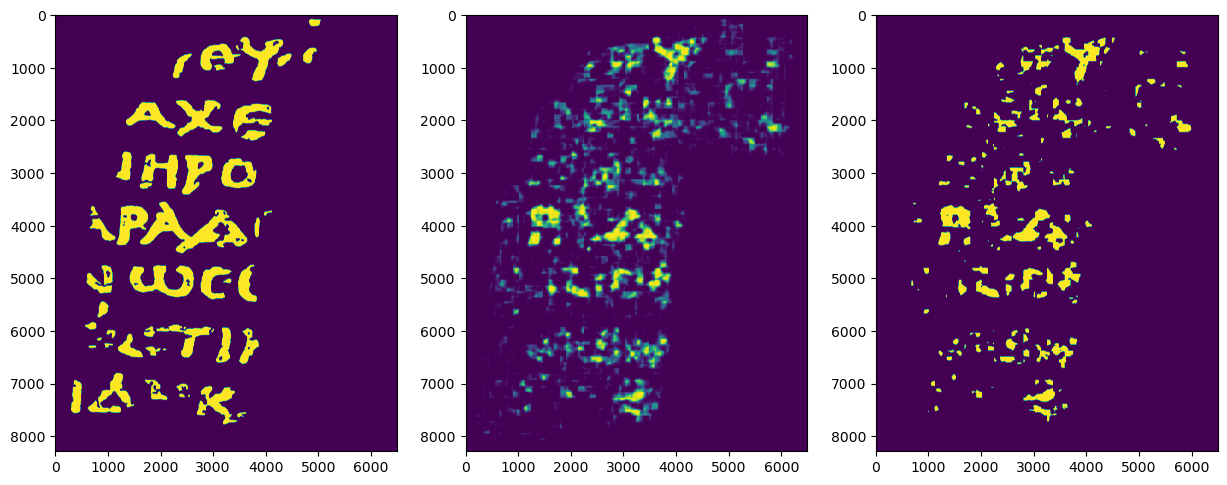

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([45425868.,  1592802.,  1009715.,   791569.,   635265.,   530695.,
          447181.,   392160.,   341228.,   310120.,   262315.,   228399.,
          207012.,   198426.,   184173.,   172134.,   184942.,   203918.,
          252726.,   468200.]),
 array([6.05668404e-08, 4.99606298e-02, 9.99211991e-02, 1.49881768e-01,
        1.99842338e-01, 2.49802907e-01, 2.99763476e-01, 3.49724045e-01,
        3.99684615e-01, 4.49645184e-01, 4.99605753e-01, 5.49566322e-01,
        5.99526891e-01, 6.49487461e-01, 6.99448030e-01, 7.49408599e-01,
        7.99369168e-01, 8.49329738e-01, 8.99290307e-01, 9.49250876e-01,
        9.99211445e-01]),
 <BarContainer object of 20 artists>)

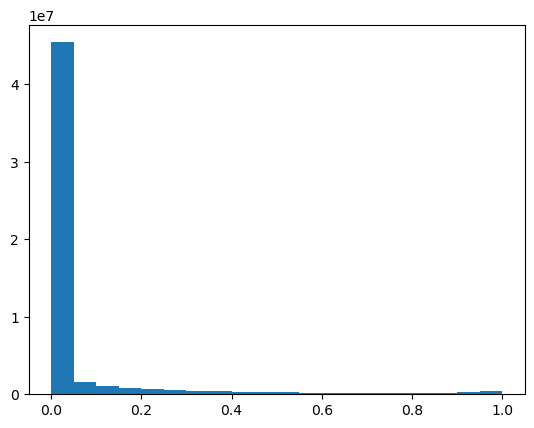

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000